In [40]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import functools as funky
from scipy import sparse

### function memoization

In [41]:
def memodict(f):
    """ Memoization decorator for a function taking a single argument """
    class memodict(dict):
        def __missing__(self, key):
            ret = self[key] = f(key)
            return ret 
    return memodict().__getitem__

### cell update functions

In [42]:
def arty(tup):
    beta, h = tup
    return 1 - 1 / (1 + np.exp(h * beta))

In [43]:
artupo = memodict(arty)

In [44]:
artyBeta = 0.75
def arty_flip(h:float):
    draw = np.random.uniform(0, 1)
    rescaled = artupo((artyBeta, h))
    if draw < rescaled:
        return 1
    else:
        return -1

### For plotting a 2d numpy.ndarray

In [45]:
def plot_nd2d(world:np.ndarray, figsize:int):
    cmap = plt.get_cmap('RdBu')
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(world, interpolation='none', cmap=cmap)

### For initializing 1d numpy.ndarray 

In [46]:
def init_world(seed:int, length:int):
    np.random.seed(seed)
    iterable = (np.random.choice(2) * 2 - 1 for i in range(length))
    return np.fromiter(iterable, np.int16)

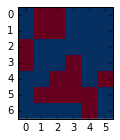

In [47]:
figSize = 6
history = [init_world(24917, figSize)]
curGen = 0
while curGen < figSize:
    newWorld = [init_world(24917 + curGen, figSize)]
    history = np.concatenate((history, newWorld), axis=0)
    curGen += 1
plot_nd2d(history, 2)

### For creating a ring graph from a sparse LIL matrix

In [48]:
def enring(m:sparse.lil_matrix, val1:float, val2:float):
    rows, cols = m.get_shape()
    currow = 0
    while currow < rows:
        m[currow, (currow + rows - 1) % rows] = val1
        m[currow, (currow + rows + 1) % rows] = val1
        m[currow, (currow + rows - 2) % rows] = val2
        m[currow, (currow + rows + 2) % rows] = val2
        currow += 1

In [49]:
def idento(m:sparse.lil_matrix, val:float):
    rows, cols = m.get_shape()
    currow = 0
    while currow < rows:
        m[currow, currow] = val
        currow += 1

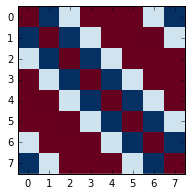

In [50]:
L = sparse.lil_matrix((8, 8))
enring(L, 1.0, 0.6)
plot_nd2d(L.toarray(), 3)

## For drawing from an exponential distribution without replacement

In [51]:
def bounded_exp_int(scale:float, low_bound:int, hi_bound:int):
    while True:
        tv = int(np.random.exponential(scale=scale))
        if (tv > low_bound) and (tv < hi_bound):
            return tv

In [52]:
def bounded_exp_int_wo_rep(scale:float, low_bound:int, hi_bound:int, count:int):
    choices = []
    while True:
        tv = bounded_exp_int(scale, low_bound, hi_bound)
        if tv not in choices:
            choices.append(tv)
        if len(choices) == count:
            return choices

In [53]:
def exp_draws_signed_pairs(scale:float, low_bound:int, hi_bound:int, pairs_count:int):
    leftSide = bounded_exp_int_wo_rep(scale = scale, low_bound = low_bound, hi_bound = hi_bound, count = pairs_count)
    rightSide = bounded_exp_int_wo_rep(scale = scale, low_bound = low_bound, hi_bound = hi_bound, count = pairs_count)
    return rightSide + [-i for i in leftSide]

In [54]:
def sparse_exp_links(scale:float, low_bound:int, span:int, pairs_count:int):
    currow = 0
    while currow < span:
        cols = exp_draws_signed_pairs(scale, low_bound = low_bound, hi_bound = span / 2, pairs_count = pairs_count)
        for col in cols:
            yield (currow, (currow + col + span) % span)
        currow += 1

In [55]:
[k for k in sparse_exp_links(scale = 1, low_bound = 1, span = 5, pairs_count = 1)]

[(0, 2),
 (0, 3),
 (1, 3),
 (1, 4),
 (2, 4),
 (2, 0),
 (3, 0),
 (3, 1),
 (4, 1),
 (4, 2)]

In [56]:
def exp_sparse(m:sparse.lil_matrix, scale:float, pairs_count:int, val:float):
        rows, cols = m.get_shape()
        for row, col in sparse_exp_links(scale = scale, low_bound = 1, span = cols, pairs_count = pairs_count):
            m[row, col] = val

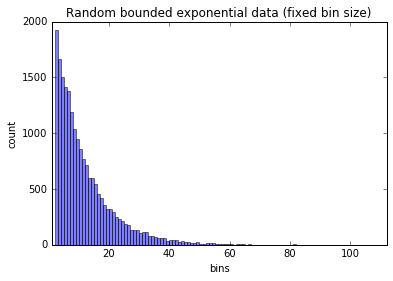

In [57]:
#data = np.random.normal(0, 10, 1000) 
data = list(bounded_exp_int(10, 1, 10000) for i in range(20000))
# fixed bin size
bins = np.arange(-100, 100, 1) # fixed bin size

plt.xlim([min(data)-1, max(data) + 1])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Random bounded exponential data (fixed bin size)')
plt.xlabel('bins')
plt.ylabel('count')

plt.show()

## For drawing from an exponential distribution with replacement

In [58]:
def bounded_exp_int_w_rep(scale:float, low_bound:int, hi_bound:int, count:int):
    choices = []
    while True:
        tv = bounded_exp_int(scale, low_bound, hi_bound)
        choices.append(tv)
        if len(choices) == count:
            return choices

In [59]:
def exp_draws_signed_pairs2(scale:float, low_bound:int, hi_bound:int, pairs_count:int):
    leftSide = bounded_exp_int_w_rep(scale = scale, low_bound = low_bound, hi_bound = hi_bound, count = pairs_count)
    rightSide = bounded_exp_int_w_rep(scale = scale, low_bound = low_bound, hi_bound = hi_bound, count = pairs_count)
    return rightSide + [-i for i in leftSide]

In [60]:
def sparse_exp_links2(scale:float, low_bound:int, span:int, pairs_count:int):
    currow = 0
    while currow < span:
        cols = exp_draws_signed_pairs2(scale, low_bound = low_bound, hi_bound = span / 2, pairs_count = pairs_count)
        for col in cols:
            yield (currow, (currow + col + span) % span)
        currow += 1

In [61]:
def exp_sparse2(m:sparse.lil_matrix, scale:float, pairs_count:int, val:float):
        rows, cols = m.get_shape()
        for row, col in sparse_exp_links2(scale = scale, low_bound = -1, span = cols, pairs_count = pairs_count):
            m[row, col] += val

## Update functions

In [62]:
def update_world(cnxns:np.ndarray, data:np.ndarray):
    inputs = cnxns.dot(data)
    return np.fromiter((arty_flip(inputs[i]) for i in range(len(data))), np.int16)

In [63]:
def batchWorld(cnxns:np.ndarray, world:np.ndarray, batchSize:int):
    currow = 0
    while currow < batchSize:
        world = update_world(cnxns, world)
        currow += 1
    return world

In [64]:
def batchWorldHist(cnxns:np.ndarray, world:np.ndarray, batchSize:int):
    history = [world]
    currow = 0
    newWorld = world
    while currow < batchSize:
        newWorld = update_world(cnxns, newWorld)
        history = np.concatenate((history, [newWorld]), axis=0)
        currow += 1
    return (newWorld, history)

# plot_nd2d(history, 2)

## Ising 1d connection matrix

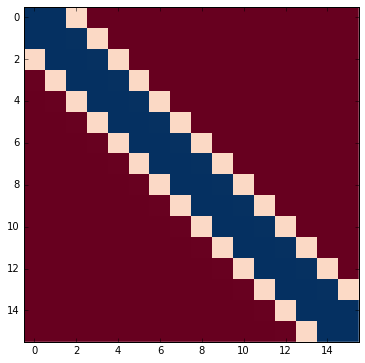

In [65]:
stride = 256 #16384
L = sparse.lil_matrix((stride, stride))
enring(L, 1.0,  0.4)
idento(L, 1.0)
plot_nd2d(L.toarray()[:16,:16], 6)

## "Small world" connection matrix.

In [66]:
stride = 256 # 16384
scale = 4
pairs_count = 8
val = 0.2125
Expo = sparse.lil_matrix((stride, stride))
exp_sparse2(m = Expo, scale = scale, pairs_count = pairs_count, val = val)

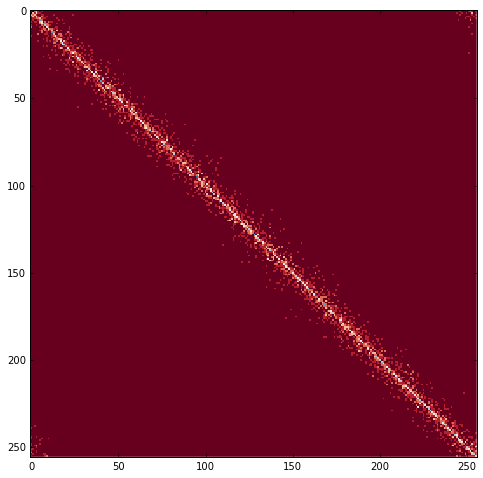

In [67]:
plot_nd2d(Expo.toarray()[ : , : ], 8)

In [68]:
 [ (Expo[i,i], Expo[i,i+1], Expo[i,i+2] ) for i in range(10) ]

[(0.42499999999999999, 0.0, 0.42499999999999999),
 (0.63749999999999996, 0.21249999999999999, 0.84999999999999998),
 (0.63749999999999996, 0.21249999999999999, 0.0),
 (0.63749999999999996, 0.21249999999999999, 0.0),
 (0.42499999999999999, 0.63749999999999996, 0.21249999999999999),
 (1.4874999999999998, 0.42499999999999999, 0.0),
 (0.84999999999999998, 0.0, 0.42499999999999999),
 (0.42499999999999999, 0.42499999999999999, 0.42499999999999999),
 (1.2749999999999999, 0.42499999999999999, 0.42499999999999999),
 (1.0625, 0.42499999999999999, 0.0)]

In [69]:
# [ (i, L[0, i] ) for i in range(stride) if  L[0, i] > 0 ]

In [70]:
start_world = init_world(1235, stride)

In [71]:
%timeit Expo.dot(start_world)

1000 loops, best of 3: 578 µs per loop


### Show the input values generated from the matrix with start_world

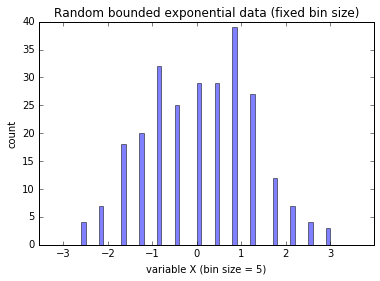

In [72]:
inputs = Expo.dot(start_world)

# create histogram
bins = np.arange(-100, 100, 0.1) # fixed bin size
plt.xlim([min(inputs)-1, max(inputs) + 1])
plt.hist(inputs, bins=bins, alpha=0.5)
plt.title('Random bounded exponential data (fixed bin size)')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()

In [73]:
%timeit batchWorld(cnxns=Expo, world=start_world, batchSize=25)

10 loops, best of 3: 35 ms per loop


In [74]:
%timeit batchWorldHist(cnxns=Expo, world=start_world, batchSize=25)

10 loops, best of 3: 34.9 ms per loop


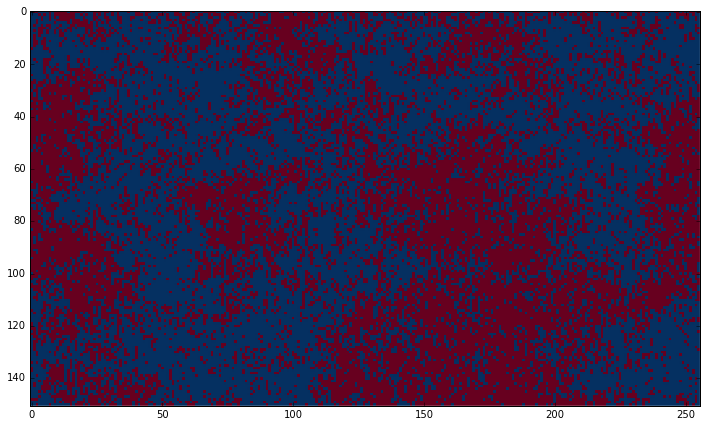

In [75]:
last, hist = batchWorldHist(cnxns=Expo, world=start_world, batchSize=150)
plot_nd2d(hist[: , : ], 12)

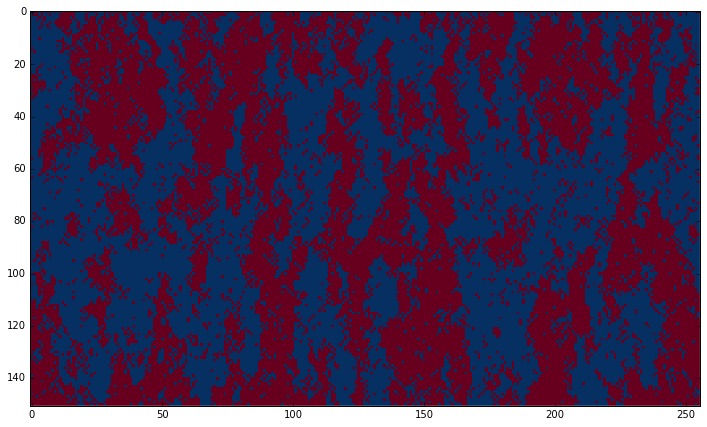

In [76]:
start_world2 = init_world(245, stride)
last, hist = batchWorldHist(cnxns=L, world=start_world2, batchSize=150)
plot_nd2d(hist[: , : ], 12)